In [259]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import CoraFull, BitcoinOTC
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
import pandas as pd
import numpy as np

#### Create Dataset

In [291]:
dataset = CoraFull("./cora")

Processing...
Done!


In [305]:
dataset.num_classes

70

### Trash

In [ ]:
sorted_ratings = pd.read_csv("../datasets/movielens/sorted_ratings.csv", header=None)

In [85]:
num_nodes = np.unique(np.hstack((sorted_ratings[0].unique(), sorted_ratings[1].unique()))).size
x = np.random.normal(size=(num_nodes, 7))
edge_index = torch.tensor(np.vstack((sorted_ratings[0].values, sorted_ratings[1].values)))

data = Data(x=x, edge_index=edge_index)


In [108]:
data.num_node_features = 7

### Model Definitions

In [306]:
class GraphSage(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(64,64),
            torch.nn.Linear(64, dataset.num_classes)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        if self.training:
            x = F.dropout(x, 0.2)
        x = self.ff(x)
        return F.softmax(x)
model = GraphSage()

### Training Loop for 2 layered GCN Normal

In [307]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
losses = list()

GraphSage(
  (conv1): SAGEConv(8710, 128)
  (conv2): SAGEConv(128, 64)
  (ff): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=70, bias=True)
  )
)

In [310]:


for epoch in range(50):
    optimizer.zero_grad()
    out = model(dataset[0])
    loss = F.cross_entropy(out, dataset[0].y)
    loss.backward()
    optimizer.step()
    print(loss)
    losses.append(loss.detach())
    


/var/folders/w0/7zdj3jy55nbfjlghkr0pc_lh0000gn/T/ipykernel_12247/960677310.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor(4.0841, grad_fn=<NllLossBackward0>)
tensor(4.0728, grad_fn=<NllLossBackward0>)
tensor(4.0433, grad_fn=<NllLossBackward0>)
tensor(4.0221, grad_fn=<NllLossBackward0>)
tensor(3.9968, grad_fn=<NllLossBackward0>)
tensor(3.9678, grad_fn=<NllLossBackward0>)
tensor(3.9513, grad_fn=<NllLossBackward0>)
tensor(3.9289, grad_fn=<NllLossBackward0>)
tensor(3.9119, grad_fn=<NllLossBackward0>)
tensor(3.8989, grad_fn=<NllLossBackward0>)
tensor(3.8871, grad_fn=<NllLossBackward0>)
tensor(3.8781, grad_fn=<NllLossBackward0>)
tensor(3.8699, grad_fn=<NllLossBackward0>)
tensor(3.8611, grad_fn=<NllLossBackward0>)
tensor(3.8544, grad_fn=<NllLossBackward0>)
tensor(3.8499, grad_fn=<NllLossBackward0>)
tensor(3.8453, grad_fn=<NllLossBackward0>)
tensor(3.8403, grad_fn=<NllLossBackward0>)
tensor(3.8380, grad_fn=<NllLossBackward0>)
tensor(3.8347, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

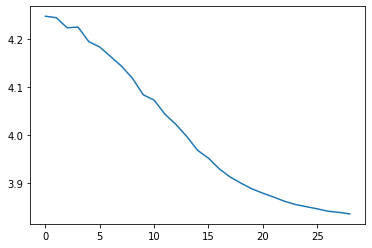

In [311]:
plt.plot(range(0, len(losses) ),losses)

2022-05-06


In [328]:
import datetime
torch.save(model, "./models/GraphSage-Cora-%s"%datetime.datetime.now().date())